# Weakly-supervised Semantic Segmentation

In [313]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [314]:
import os
from pathlib import Path
import re

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [315]:
from config import IMAGE_DATA_DIR, TILES_DIR, LABELS, RED, BLACK, N1, N2, N_validation, CODES

In [316]:
BASE_DIR = Path('').absolute().parent; BASE_DIR

PosixPath('/home/jupyter/weakly-supervised-semseg')

In [317]:
image_tiles_fnames = os.listdir(BASE_DIR / TILES_DIR)

In [318]:
fname = image_tiles_fnames[0]; fname

'top_mosaic_09cm_area27_tile154_11100.tif'

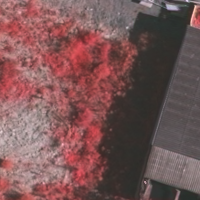

In [319]:
img = open_image(BASE_DIR / TILES_DIR / fname)
img

In [320]:
src_size = np.array(img.shape[1:]); src_size

array([200, 200])

### Load data

In [321]:
base_path = "top_mosaic_09cm_area"
prog_label_vector = re.compile(base_path + r"\d+_tile\d+_(?P<label_vector>\d{5}).tif")

def get_y_fn(x):
    fname = x.name
    match_result = prog_label_vector.search(fname)
    label_vector = match_result.group('label_vector')
    label_vector_arr = torch.tensor(list(map(int,label_vector))) # NEW

    indexes = torch.where(label_vector_arr == 1)[0]
    colors = [LABELS[idx] for idx in indexes]
    
    return colors

In [322]:
# # DEBUG
# # Example: top_mosaic_09cm_area27_tile154_11100.tif
# fpath = BASE_DIR / TILES_DIR / fname
# result = get_y_fn(fpath)
# type(result), result

In [323]:
free = gpu_mem_get_free_no_cache(); free

8487

In [324]:
base_path = "top_mosaic_09cm_area"
prog_with_label_vector = re.compile(base_path + r"(?P<area_id>\d+)_tile(?P<tile_id>\d+)_(?P<label_vector>\d{5}).tif")

def is_in_set(x, N):
    fname = x.name  # e.g.: top_mosaic_09cm_area30_tile120.tif'

    match_result = prog_with_label_vector.search(fname)
    area_id = match_result.group('area_id')
    tile_id = match_result.group('tile_id')
    image_fname = f"{base_path}{area_id}.tif"  # e.g.: top_mosaic_09cm_area30.tif'
    return image_fname in N

is_in_set_n1 = partial(is_in_set, N=N1)
is_in_set_n2 = partial(is_in_set, N=N2)
is_in_set_nvalidation = partial(is_in_set, N=N_validation)
is_in_set_n2_or_nvalidation = partial(is_in_set, N=N2+N_validation)

src_size = np.array(img.shape[1:])
src_size,img.data
size = src_size // 2  # TODO

# codes = CODES
# codes = LABELS+[RED, BLACK]

item_list = (ImageList.from_folder(BASE_DIR / TILES_DIR)  #returns ImageList
             .filter_by_func(is_in_set_n2_or_nvalidation)  #returns ImageList
             .split_by_valid_func(is_in_set_nvalidation)  #returns ItemLists(ImageList, ImageList)
             .label_from_func(get_y_fn, classes=LABELS)  #returns LabelLists(CategoryList, ItemList)
             .transform(get_transforms(), size=size)
            )

In [325]:
item_list

LabelLists;

Train: LabelList (3172 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: MultiCategoryList
(255, 255, 255);(0, 0, 255);(0, 255, 255),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255),(255, 255, 255);(0, 0, 255);(0, 255, 255)
Path: /home/jupyter/weakly-supervised-semseg/data/ISPRS_semantic_labeling_Vaihingen/top_weaklabel_tiles;

Valid: LabelList (935 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: MultiCategoryList
(255, 255, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(255, 255, 0),(255, 255, 255);(0, 255, 255);(0, 255, 0);(255, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 0);(255, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0);(255, 255, 0)
Path: /home/jupyter/weakly-supervised-semseg

In [326]:
# DEBUG
item_list.train.y[0]

MultiCategory [1. 1. 1. 0. 0.]

In [327]:
# item_list.train.items[0]
item_list.train.c

5

In [328]:
bs = 2 # TODO
data = item_list.databunch(bs=bs).normalize(imagenet_stats)
data.c = 5

In [329]:
data.classes[:10], len(data.classes)

([(255, 255, 255), (0, 0, 255), (0, 255, 255), (0, 255, 0), (255, 255, 0)], 5)

In [330]:
data

ImageDataBunch;

Train: LabelList (3172 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: MultiCategoryList
(255, 255, 255);(0, 0, 255);(0, 255, 255),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255),(255, 255, 255);(0, 0, 255);(0, 255, 255)
Path: /home/jupyter/weakly-supervised-semseg/data/ISPRS_semantic_labeling_Vaihingen/top_weaklabel_tiles;

Valid: LabelList (935 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: MultiCategoryList
(255, 255, 255);(0, 255, 255);(0, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(255, 255, 0),(255, 255, 255);(0, 255, 255);(0, 255, 0);(255, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 0);(255, 255, 0),(255, 255, 255);(0, 0, 255);(0, 255, 255);(0, 255, 0);(255, 255, 0)
Path: /home/jupyter/weakly-supervised-se

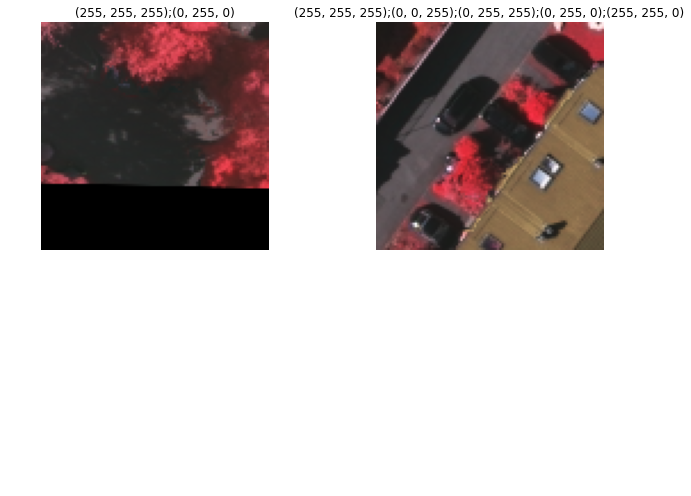

In [331]:
data.show_batch(2, figsize=(10,7))

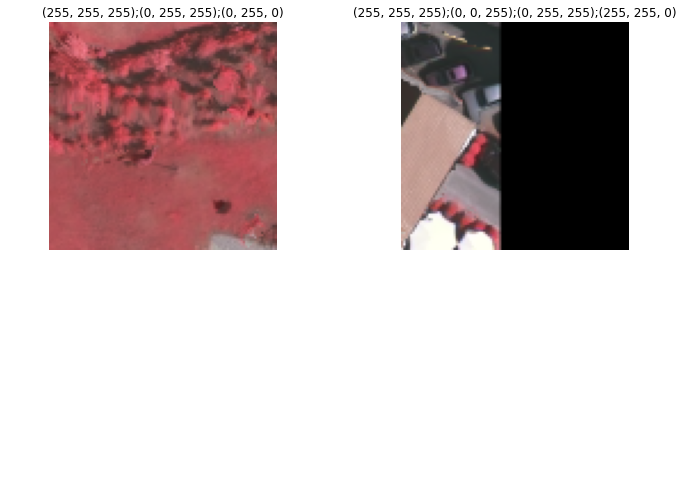

In [332]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [333]:
# item_list

# all tiles: 4497
# 935 / 4497 = 20%
# 390 / 4497 = 8.6%

# This seems to be the desired split

## Model

Train and compare semantic segmentation networks, using the following data: Task (i) N1 pixel level labels

In [334]:
wd=1e-2

In [335]:
from loss_custom import WeakCrossEntropy

learn = unet_learner(data, 
                     models.resnet18, 
                     loss_func=WeakCrossEntropy(CODES, axis=1),
#                      metrics=acc_satellite, 
                     wd=wd,
                    )

In [336]:
# lr_find(learn)
# learn.recorder.plot()

In [337]:
lr=3e-4

In [338]:
learn.fit_one_cycle(1, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,time


AssertionError: tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='cuda:0',
       grad_fn=<SumBackward1>)

In [80]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_satellite,time
0,0.542927,0.662751,0.750796,00:04
1,0.540022,0.631123,0.757926,00:04
2,0.538993,0.636819,0.760271,00:04
3,0.532967,0.661279,0.757744,00:04
4,0.527271,0.659029,0.752781,00:04
5,0.523080,0.651510,0.755258,00:04
6,0.524579,0.718067,0.729373,00:04
7,0.532874,0.613680,0.765763,00:04
8,0.530841,0.654643,0.759037,00:04
9,0.526845,0.613699,0.764926,00:04


In [81]:
learn.save('stage-1')

In [91]:
learn.load('stage-1');

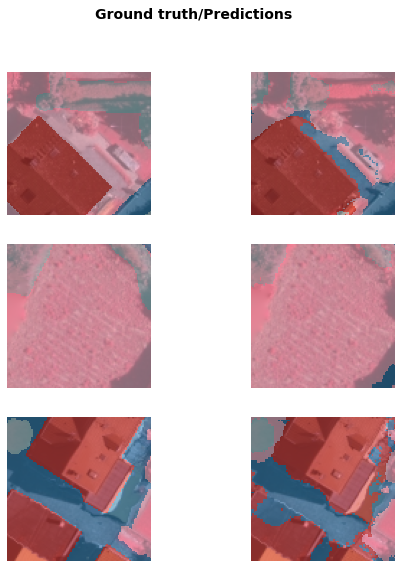

In [85]:
learn.show_results(rows=3, figsize=(8,9))